# Exploring Gender Bias in Word Embedding

This assignment has been adapted from a responsibly tutorial. You can read more about responsibly [here](https://learn.responsibly.ai/word-embedding).

# Part 1: Setup

## 1.1 - Install packages

- make a conda environment with strictly less than Python 3.8 but greater than or equal to Python 3.6

- **Install numpy and matplotlib (v2.2.3) through conda**

- conda install numpy

- conda install matplotlib=2.2.3

- pip install responsibly

In [215]:
from IPython.display import Image
import responsibly
import warnings
from numpy.linalg import norm
from math import acos, degrees
from sklearn.manifold import TSNE
from matplotlib import pylab as plt
from responsibly.we import most_similar
from responsibly.we import GenderBiasWE
import matplotlib.pylab as plt
from operator import itemgetter
from responsibly.we import load_w2v_small
from copy import deepcopy
from sklearn.feature_extraction.text import CountVectorizer
from numpy.testing import assert_almost_equal
from numpy.linalg import norm
from responsibly.we.weat import _filter_by_model_weat_stimuli
from responsibly.we import calc_all_weat
from responsibly.we import calc_single_weat
from responsibly.we import GenderBiasWE

## 1.2 - Validate Installation of `responsibly`

In [216]:
# You should get '0.1.3'
responsibly.__version__

'0.1.3'

# Part 2: Motivation - Why use word embeddings?

## 2.1 - [NLP (Natural Language Processing)](https://en.wikipedia.org/wiki/Natural_language_processing)

Partial list of tasks and applications:

- Classification
- Machine Translation
- Information Retrieval
- Conversation Chatbots
- Coreference Resolution

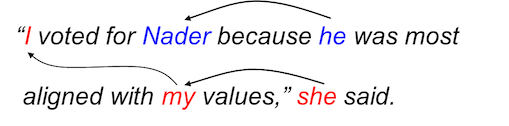

In [217]:
Image("./images/corefexample.png", width=600)


<small>Source: [Stanford Natural Language Processing Group](https://nlp.stanford.edu/projects/coref.shtml)</small>

## 2.2 - Machine Learning (NLP) Pipeline

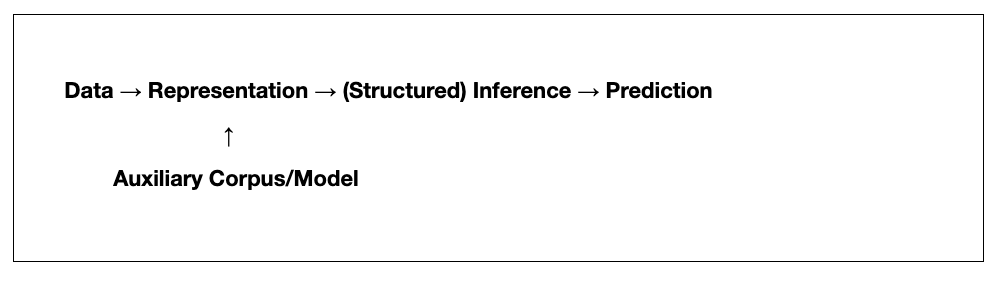

In [218]:
Image("./images/nlp-pipeline.png", width=600)


<small>Source: [Kai-Wei Chang (UCLA) - What It Takes to Control Societal Bias in Natural Language Processing](https://www.youtube.com/watch?v=RgcXD_1Cu18)</small>

## 2.3 - How can we represent language to a machine?

We need some kind of *dictionary* to transform/encode from a human representation to a machine representation (words → numbers)

### Bag of Words (for a text)


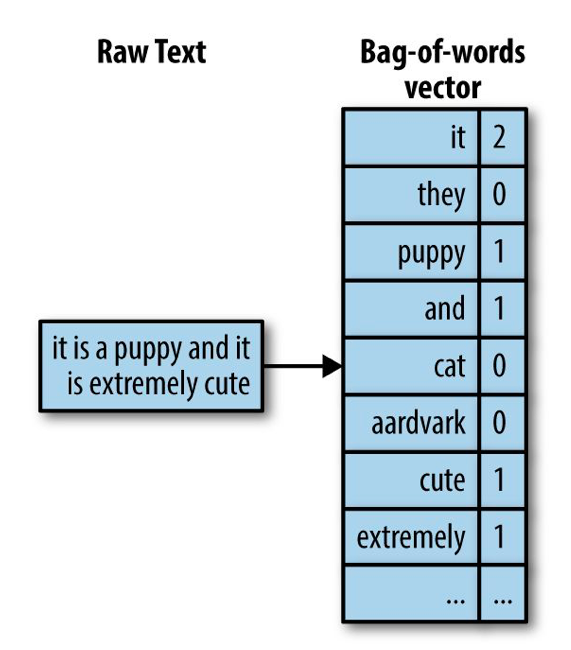

In [219]:
Image("./images/bow.png", width=300)

<small>Source: Zheng, A.& Casari, A. (2018). Feature Engineering for Machine Learning. O'Reilly Media.</small>

In [220]:
vocabulary = ['it', 'they', 'puppy', 'and', 'cat', 'aardvark', 'cute', 'extremely', 'not']

vectorizer = CountVectorizer(vocabulary=vocabulary)

In [221]:
sentence = 'it is a puppy and it is extremely cute'

In [222]:
vectorizer.fit_transform([sentence]).toarray()

array([[2, 0, 1, 1, 0, 0, 1, 1, 0]])

In [223]:
vectorizer.fit_transform(['it is not a puppy and it is extremely cute']).toarray()

array([[2, 0, 1, 1, 0, 0, 1, 1, 1]])

In [224]:
vectorizer.fit_transform(['it is a puppy and it is extremely not cute']).toarray()

array([[2, 0, 1, 1, 0, 0, 1, 1, 1]])

Read more about scikit-learn's text feature extraction [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

### One-hot representation

In [225]:
[vectorizer.fit_transform([word]).toarray()
 for word in sentence.split()
 if word in vocabulary]

[array([[1, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 1, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0, 0, 0, 0, 0]]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 array([[0, 0, 0, 0, 0, 0, 1, 0, 0]])]

### A problem with one-hot representation


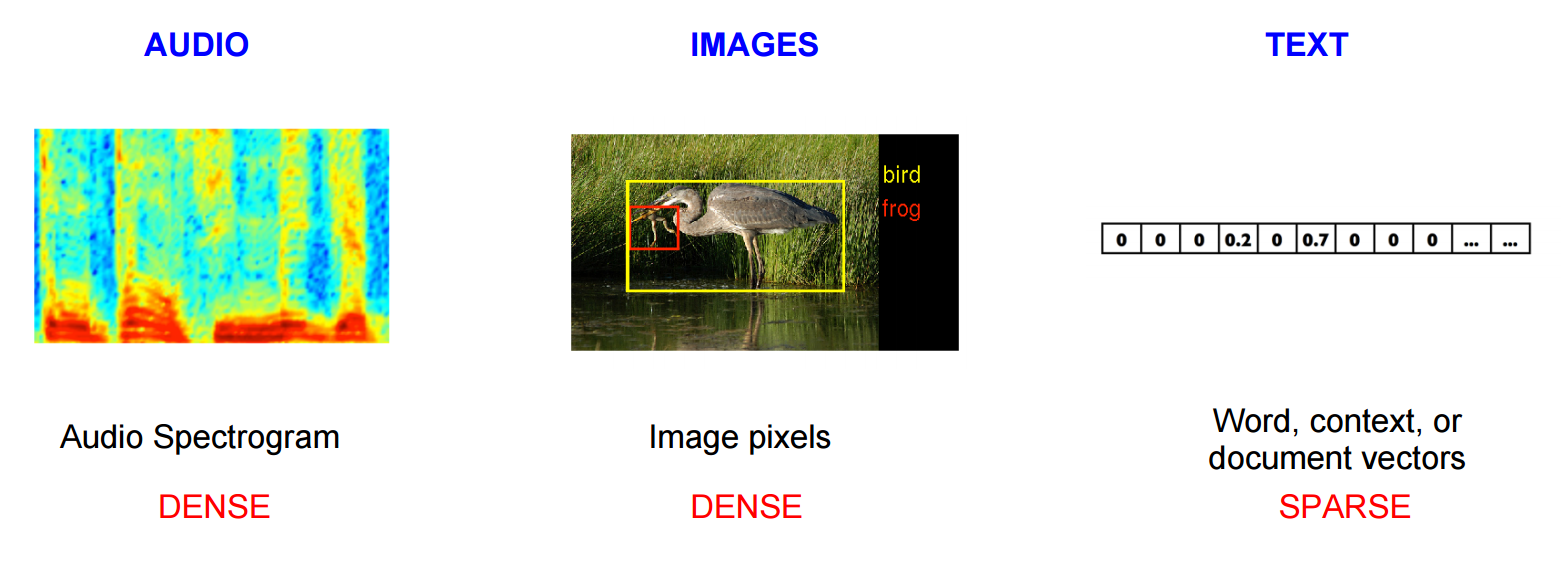

In [226]:
Image("./images/audio-image-text.png", width=600)

<small> Source: [Tensorflow Documentation](https://www.tensorflow.org/tutorials/representation/word2vec) </small>

### Embedding a word in a n-dimensional space

Distance ~ Semantic Similarity

Again, for the purposes of this assignment, these are just references and additional sources of information. You should have already seen "The Illustrated Word2vec" by Jay Alammar.

#### Examples (algorithms and pre-trained models)
- [Word2Vec](https://code.google.com/archive/p/word2vec/)
- [GloVe](https://nlp.stanford.edu/projects/glove/)
- [fastText](https://fasttext.cc/)
- [ELMo](https://allennlp.org/elmo) (contextualized)

#### Training: using *word-context* relationships from a corpus.

See: [The Illustrated Word2vec by Jay Alammar](http://jalammar.github.io/illustrated-word2vec/)

#### State of the Art - Contextual Word Embedding → Language Models
- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning) by Jay Alammar](http://jalammar.github.io/illustrated-bert/)
- Microsoft - [NLP Best Practices](https://github.com/microsoft/nlp-recipes)
- [Tracking Progress in Natural Language Processing](https://nlpprogress.com/)

## 🐳 **Questions** 🐳

+ Can you think of a use case where one-hot encoding or a bag of words approach would be better than a high-dimensional word embedding? If so, why? If not, why not?

# Part 3: Playing with Word2Vec word embeddings


[Word2Vec](https://code.google.com/archive/p/word2vec/) - Google News - 100B tokens, 3M vocab, cased, 300d vectors - only lowercase vocab extracted

Loaded using [`responsibly`](http://docs.responsibly.ai) package, the function [`responsibly.we.load_w2v_small`]() returns a [`gensim`](https://radimrehurek.com/gensim/)'s [`KeyedVectors`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors) object.

## 3.1 - Basic Properties

In [227]:
# ignore warnings
# generally, you shouldn't do that, but for this tutorial we'll do so for the sake of simplicity
warnings.filterwarnings('ignore')

In [228]:
# this loads a small version of Word2Vec which does not include the full vocabulary 
w2v_small = load_w2v_small()

In [229]:
# vocabulary size
len(w2v_small.vocab)

26423

In [230]:
# get the vector of the word "home"
print('home =', w2v_small['home'])

home = [-0.00584168  0.0392657   0.00831084 -0.0443245   0.0426382   0.0119243
  0.0125867  -0.0934669   0.0698593   0.0416747   0.0838311  -0.123338
 -0.0263779  -0.0139718   0.0224031  -0.07275     0.00605246  0.0278233
  0.00963576  0.106475    0.0775679  -0.0785314   0.0436018  -0.052274
 -0.00201749 -0.0115027  -0.0243303   0.0402293   0.0187897   0.00087324
  0.027221    0.0184284  -0.0722682  -0.0187897  -0.027221    0.00560078
 -0.0387839  -0.0737135   0.0445654   0.0183079   0.0436018  -0.00731715
  0.0900943   0.047697   -0.027221    0.0804586   0.0195124   0.0809404
  0.0414338   0.0137912  -0.016983    0.146464    0.0693775   0.0486606
 -0.0910579  -0.130083   -0.0597417   0.0900943   0.0112618  -0.0209578
 -0.0101778   0.0407111  -0.00069257  0.0110811  -0.0375795   0.0133696
 -0.0232463   0.0278233  -0.00123458  0.0558874   0.063596   -0.047697
  0.0332434  -0.0402293  -0.0520331   0.0344478  -0.011322    0.0030714
  0.00909375 -0.0128878   0.0285459   0.0380612   0.00502

In [231]:
# the word embedding dimension, in this case, is 300

len(w2v_small['home'])

300

In [232]:
# all the words are normalized (=have norm equal to one as vectors)

norm(w2v_small['home'])

1.0

In [233]:
# make sure that all the vectors are normalized!

length_vectors = norm(w2v_small.vectors, axis=1)

assert_almost_equal(actual=length_vectors,
                    desired=1,
                    decimal=5)

## 3.2 - Mesuring Distance between Words

### Mesure of Similiarty: [Cosine Similariy](https://en.wikipedia.org/wiki/Cosine_similarity)
- Measures the cosine of the angle between two vecotrs.
- Ranges between 1 (same vector) to -1 (opposite/antipode vector)
- In Python, for normalized vectors (Numpy's array), use the `@`(at) operator!

In [234]:
w2v_small['cat'] @ w2v_small['cat']

1.0000006

In [235]:
w2v_small['cat'] @ w2v_small['cats']

0.8099383

In [236]:
degrees(acos(w2v_small['cat'] @ w2v_small['cats']))

35.910095270739426

In [237]:
w2v_small['cat'] @ w2v_small['dog']

0.76094615

In [238]:
degrees(acos(w2v_small['cat'] @ w2v_small['dog']))

40.45232006805675

In [239]:
w2v_small['cat'] @ w2v_small['cow']

0.40352482

In [240]:
degrees(acos(w2v_small['cat'] @ w2v_small['cow']))

66.20128249356603

In [241]:
w2v_small['cat'] @ w2v_small['graduated']

-0.0037888326

In [242]:
degrees(acos(w2v_small['cat'] @ w2v_small['graduated']))

90.21708463522016

In general, the use of word embeddings to encode words, as an input for NLP systems*, improves their performance compared to one-hot representation.

\* Sometimes the embedding is learned as part of the NLP system.

## 3.3 - Visualizing Word Embedding in 2D using T-SNE

<small>Source: [Google's Seedbank](https://research.google.com/seedbank/seed/pretrained_word_embeddings)</small>

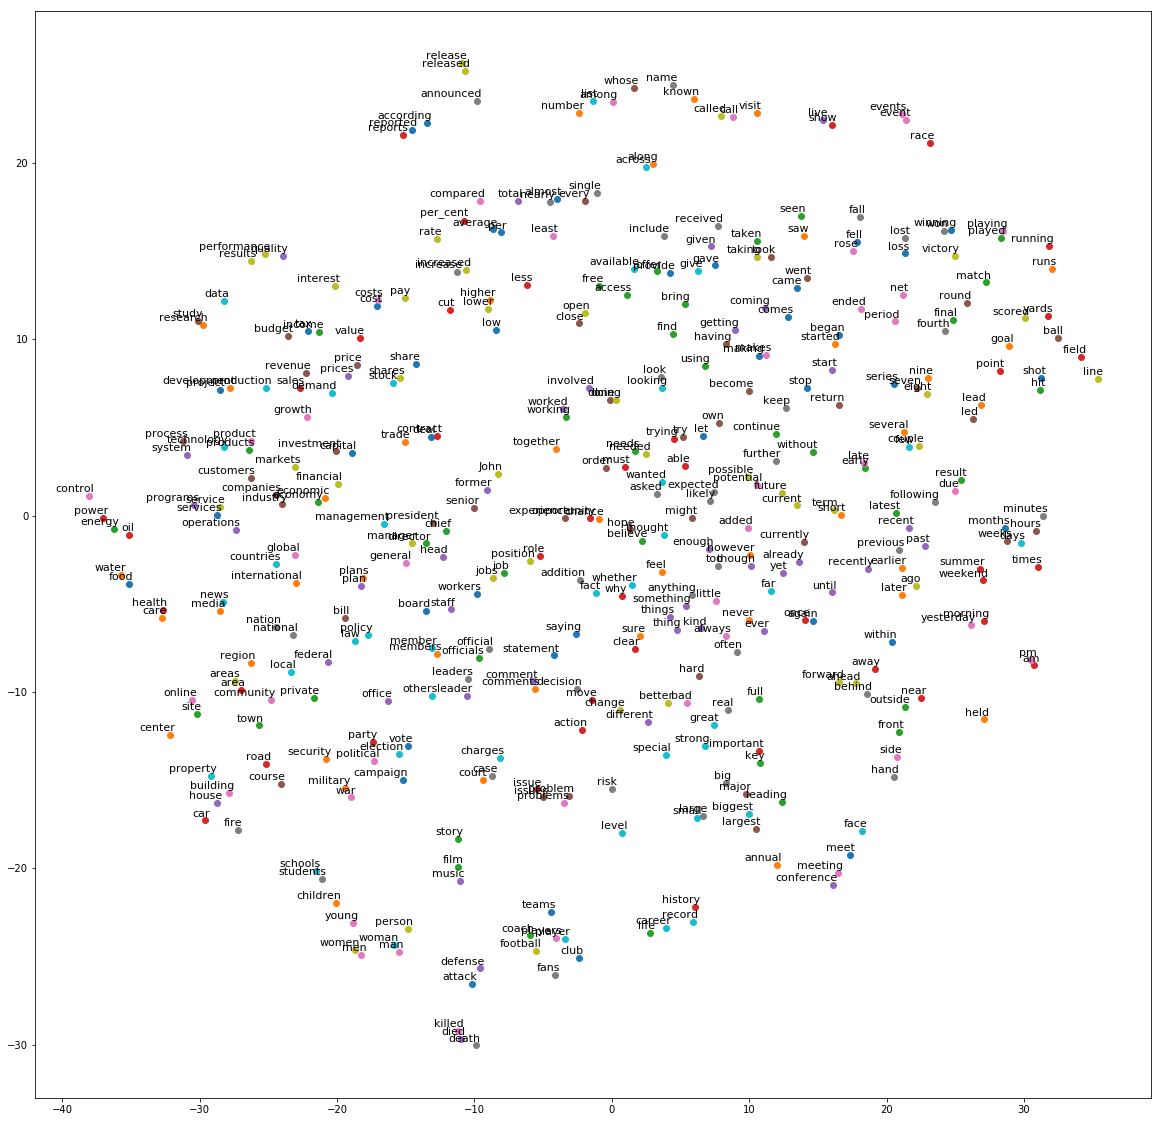

In [243]:


# take the most common words in the corpus between 200 and 600
words = [word for word in w2v_small.index2word[200:600]]

# convert the words to vectors
embeddings = [w2v_small[word] for word in words]

# perform T-SNE
words_embedded = TSNE(n_components=2).fit_transform(embeddings)

# ... and visualize!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

#### Extra: [Tensorflow Embedding Projector](http://projector.tensorflow.org)

## 3.4 - Most Similar

What are the most simlar words to a given word?

In [244]:
w2v_small.most_similar('cat')

[('cats', 0.8099379539489746),
 ('dog', 0.7609457969665527),
 ('kitten', 0.7464984059333801),
 ('feline', 0.7326232194900513),
 ('puppy', 0.707545280456543),
 ('pup', 0.6934290528297424),
 ('pet', 0.6891530752182007),
 ('pooch', 0.6699831485748291),
 ('poodle', 0.6621246337890625),
 ('dogs', 0.6418520212173462)]

Given a list of words, which one doesn't match?

(The word furthest away from the mean of all words.)

In [245]:
w2v_small.doesnt_match('breakfast cereal dinner lunch'.split())

'cereal'

## 3.5 - Vector Arithmetic

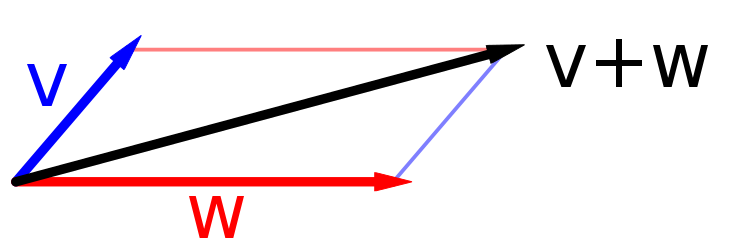

In [246]:
Image("./images/vector-addition.png", width="400")


<small>Source: [Wikipedia](https://commons.wikimedia.org/wiki/File:Vector_add_scale.svg)</small>

In [247]:
# nature + science = ?

w2v_small.most_similar(positive=['nature', 'science'])

[('biology', 0.5784977674484253),
 ('ecology', 0.5561813116073608),
 ('scientific', 0.5484972596168518),
 ('sciences', 0.5216706991195679),
 ('physics', 0.49387651681900024),
 ('geography', 0.4893345832824707),
 ('geology', 0.4885982275009155),
 ('mathematics', 0.48719534277915955),
 ('humanities', 0.48349493741989136),
 ('astronomy', 0.46454447507858276)]

## 3.6 - Vector Analogy

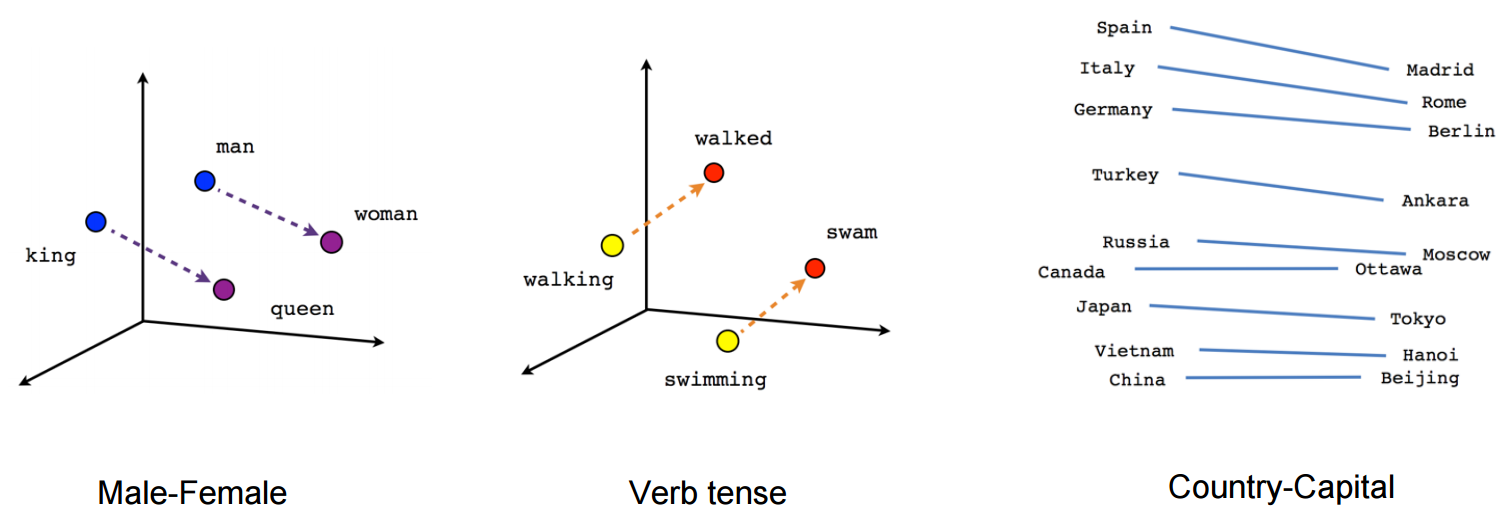

In [248]:
Image("./images/linear-relationships.png", width=800)

<small>Source: [Tensorflow Documentation](https://www.tensorflow.org/tutorials/representation/word2vec)</small>

We now try to represent the following analogy: 

*king is to man as ____ is to woman*

We can think of this as $\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman}$

In [249]:
w2v_small.most_similar(positive=['king', 'woman'],
                       negative=['man'])

[('queen', 0.7118192315101624),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236842632293701),
 ('queens', 0.5181134939193726),
 ('monarchy', 0.5087413787841797),
 ('throne', 0.5005807876586914),
 ('royal', 0.4938204884529114),
 ('ruler', 0.4909273684024811)]

## 3.7 - Think about a direction in word embedding as a relation

Remember: direction is not a word vector by itself

$\overrightarrow{big} - \overrightarrow{small} + \overrightarrow{smaller}$

In [250]:
w2v_small.most_similar(positive=['big', 'smaller'],
                       negative=['small'])

[('bigger', 0.7836997509002686),
 ('larger', 0.5866795778274536),
 ('biggest', 0.5240509510040283),
 ('huge', 0.5084124207496643),
 ('sharper', 0.4824290871620178),
 ('heavier', 0.4784499406814575),
 ('tougher', 0.46322107315063477),
 ('better', 0.46317416429519653),
 ('major', 0.4562188386917114),
 ('quicker', 0.45142698287963867)]

Sometimes vector arithmetic does not behave as expect. Notice how close the top two results are in the output that follows.

$\overrightarrow{up} - \overrightarrow{down} + \overrightarrow{backward}$

(we include backwards in the code, otherwise it will be the top result)

In [251]:
w2v_small.most_similar(positive=['up', 'backward', 'backwards'],
                       negative=['down'])

[('forward', 0.4221424460411072),
 ('bending', 0.42087429761886597),
 ('awkwardly', 0.41121649742126465),
 ('wrong', 0.4003015458583832),
 ('towards', 0.39588499069213867),
 ('direction', 0.3805443048477173),
 ('toward', 0.38034504652023315),
 ('opposite_direction', 0.378280371427536),
 ('twisting', 0.3676390051841736),
 ('upwards', 0.3630780279636383)]

#### Extra Information

Keep in mind the word embedding was generated by learning the co-occurrence of words, so the fact that it *empirically* exhibits "concept arithmetic", it doesn't necessarily mean it learned it! In fact, it seems it didn't.
See: [king - man + woman is queen; but why? by Piotr Migdał](https://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html)

[Demo - Word Analogies Visualizer by Julia Bazińska](https://lamyiowce.github.io/word2viz/)

In fact, `w2v_small.most_similar` finds the closest word which *is not one* of the given ones. This is a real methodological issue. Nowadays, it is not a common practice anymore to evaluate word embedding with analogies.

You can use [`responsibly.we.most_similar`](https://docs.responsibly.ai/word-embedding-bias.html#responsibly.we.utils.most_similar) for the unrestricted version.

## 🐳 **Questions** 🐳

+ What are some of the advantages and disadvantages of the 2-dimensional visualization in **3.3**?

<br>

+ What makes sense to you about what you see in the 2-dimensional visualization in **3.3** and what doesn't?

<br>

+ Why did the vector arithmetic in **3.6** appear to work but it did not in the latter part of **3.7**?

<br>

+ Find the words that are most similar to this relation: *see* is to *eye* as ___ is to *ear*

In [252]:
### Your code here

+ Pick a relation of your own and find words most similar to it. What did you expect to see, and what did you find? (Note that the dictionary used here is limited and you may have to experiment to find words that are included.)

In [253]:
### Your code here

# Part 4: Gender Bias


Remember that Word2Vec is primarily trained on Google News.

Bolukbasi Tolga, Kai-Wei Chang, James Y. Zou, Venkatesh Saligrama, and Adam T. Kalai. [Man is to computer programmer as woman is to homemaker? debiasing word embeddings](https://arxiv.org/abs/1607.06520). NIPS 2016.

In [254]:
from responsibly.we import load_w2v_small

w2v_small = load_w2v_small()

The method of generating analogies can enforce producing gender sterotyping ones -

Nissim, M., van Noord, R., van der Goot, R. (2019). [Fair is Better than Sensational: Man is to Doctor as Woman is to Doctor](https://arxiv.org/abs/1905.09866).

... and a [Twitter thread](https://twitter.com/adamfungi/status/1133865428663635968) between the authors of the two papers.

## 4.1 - What can we take from analogies?

Can we describe some sort of "gender direction"?

$\overrightarrow{she} - \overrightarrow{he}$

Notice the order - words in the "she" direction will be positive, while words in the "he" direction will be negative.

In [255]:
gender_direction = w2v_small['she'] - w2v_small['he']

gender_direction /= norm(gender_direction)

In practice, we calculate the gender direction using multiple definitional pair of words for better estimation (words may have more than one meaning):

- woman - man
- girl - boy
- she - he
- mother - father
- daughter - son
- gal - guy
- female - male
- her - his
- herself - himself
- Mary - John

## 4.2 - Projections

In [256]:
gender_direction @ w2v_small['architect']

-0.16785556

In [257]:
gender_direction @ w2v_small['interior_designer']

0.19714224

The word *architect* appears in more contexts with *he* than with *she*, and vice versa for *interior designer*.

In [258]:
w2v_small_gender_bias = GenderBiasWE(w2v_small, only_lower=True)

In [259]:
w2v_small_gender_bias.positive_end, w2v_small_gender_bias.negative_end

('she', 'he')

In [260]:
# gender direction
w2v_small_gender_bias.direction[:10]

array([-0.10056252, -0.09987912, -0.05384335,  0.00480521,  0.01521063,
       -0.01666582,  0.00932551, -0.00625998, -0.11320096,  0.03992424])

In [261]:
from responsibly.we.data import BOLUKBASI_DATA

neutral_profession_names = BOLUKBASI_DATA['gender']['neutral_profession_names']

In [262]:
neutral_profession_names[:10]

['accountant',
 'acquaintance',
 'actor',
 'adjunct_professor',
 'administrator',
 'adventurer',
 'advocate',
 'aide',
 'alderman',
 'alter_ego']

In [263]:
len(neutral_profession_names)

303

In [264]:
# this is the same as using the @ operator on the bias direction
w2v_small_gender_bias.project_on_direction(neutral_profession_names[0])

0.008421653826199162

**Let's visualize the projections of professions (neutral and specific by the orthography) on the gender direction**

Note that we visuzalize the most extreme professions

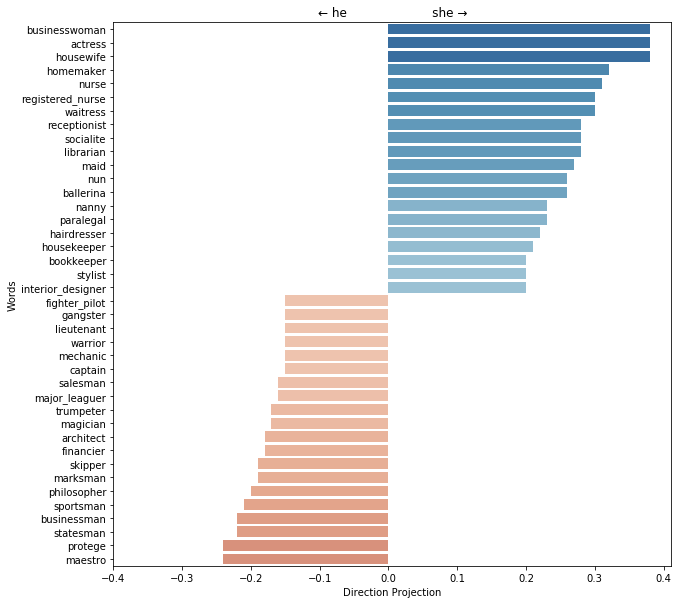

In [265]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_bias.plot_projection_scores(n_extreme=20, ax=ax);

**Extra** - Visualizing gender bias with [Word Clouds](http://wordbias.umiacs.umd.edu/)

This is an example of the type of work that you could do for a project

## 4.3 - Are the projections of occupation words on the gender direction related to the real world?

Let's take the percentage of female in various occupations from the Labor Force Statistics of 2017 Population Survey.

Taken from: [https://arxiv.org/abs/1804.06876](https://arxiv.org/abs/1804.06876)

In [266]:
from responsibly.we.data import OCCUPATION_FEMALE_PRECENTAGE

sorted(OCCUPATION_FEMALE_PRECENTAGE.items(), key=itemgetter(1))

[('carpenter', 2),
 ('mechanician', 4),
 ('construction_worker', 4),
 ('laborer', 4),
 ('driver', 6),
 ('sheriff', 14),
 ('mover', 18),
 ('developer', 20),
 ('farmer', 22),
 ('guard', 22),
 ('chief', 27),
 ('janitor', 34),
 ('lawyer', 35),
 ('cook', 38),
 ('physician', 38),
 ('ceo', 39),
 ('analyst', 41),
 ('manager', 43),
 ('supervisor', 44),
 ('salesperson', 48),
 ('editor', 52),
 ('designers', 54),
 ('accountant', 61),
 ('auditor', 61),
 ('writer', 63),
 ('baker', 65),
 ('clerk', 72),
 ('cashier', 73),
 ('counselors', 73),
 ('attendant', 76),
 ('teacher', 78),
 ('sewer', 80),
 ('librarian', 84),
 ('assistant', 85),
 ('cleaner', 89),
 ('housekeeper', 89),
 ('nurse', 90),
 ('receptionist', 90),
 ('hairdressers', 92),
 ('secretary', 95)]

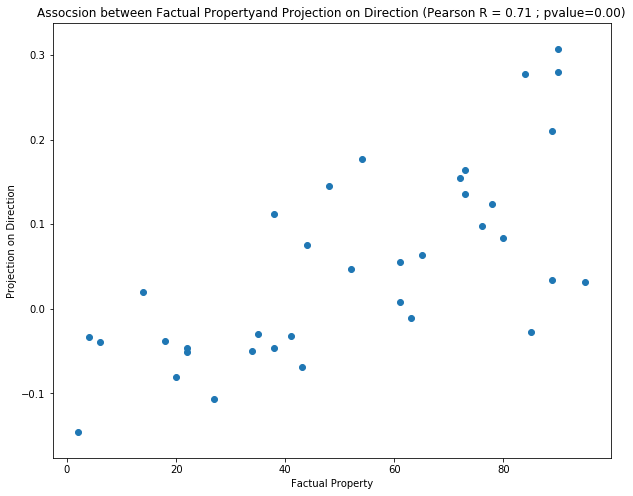

In [267]:
f, ax = plt.subplots(1, figsize=(10, 8))

w2v_small_gender_bias.plot_factual_association(ax=ax);

## 4.4 Word Embeddings Encoding Gender Stereotypes

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). [Word embeddings quantify 100 years of gender and ethnic stereotypes](https://www.pnas.org/content/pnas/115/16/E3635.full.pdf). Proceedings of the National Academy of Sciences, 115(16), E3635-E3644.

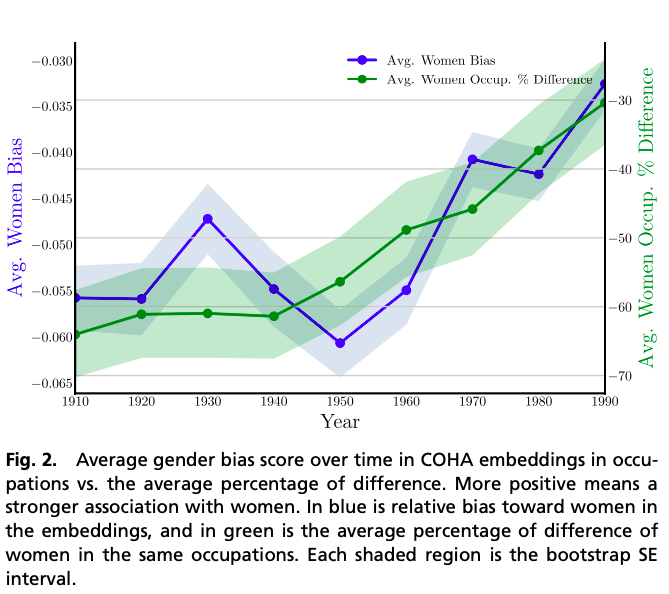

In [268]:
Image("./images/gender-bias-over-decades.png")

<small>Data: Google Books/Corpus of Historical American English (COHA)</small>

## 4.5 - Direct Bias Measure

1. Project each **neutral profession name** on the gender direction
2. Calculate the absolute value of each projection
3. Average it all

In [269]:
# using responsibly
w2v_small_gender_bias.calc_direct_bias()

0.07307905358773405

In [270]:
# what responsibly does:
neutral_profession_projections = [w2v_small[word] @ w2v_small_gender_bias.direction
                                  for word in neutral_profession_names]

abs_neutral_profession_projections = [abs(proj) for proj in neutral_profession_projections]

sum(abs_neutral_profession_projections) / len(abs_neutral_profession_projections)

0.07307905349475183

## 4.6 - Indirect Bias Measure
Similarity due to shared "gender direction" projection

In [271]:
w2v_small_gender_bias.generate_closest_words_indirect_bias('softball',
                                                           'football')

projection  indirect_bias
end      word                                       
softball bookkeeper          0.178528       0.201158
         receptionist        0.158782       0.672343
         registered_nurse    0.156625       0.287150
         waitress            0.145104       0.317843
         paralegal           0.142549       0.372737
football cleric             -0.165978       0.017845
         maestro            -0.180458       0.415805
         pundit             -0.193207       0.101227
         businessman        -0.195981       0.170078
         footballer         -0.337857       0.015365

## 🐳 **Questions** 🐳

- Building off the example in section **4.2**, calculate three additional projects of the gender direction onto three words of your choice

In [272]:
# Calculate three additional gender projections here


- What do you think of the idea of a gender direction as quantified in section **4.1** above?

    - What do you think the formula does right?

    - What do you think the formula does wrong?

- Using the methods shown in **4.1** and **4.2**, define a new direction for a concept of your choice besides gender

    - What is your concept?
    
    - What are your starting and ending words?

- Calculate the new concept direction, and project it onto three words of your choice below

In [273]:
### Calculate the new direction


### Project it onto three words of your choice

- What do your results tell you?

# Part 5: Mitigating Bias

> We intentionally do not reference the resulting embeddings as "debiased" or free from all gender bias, and
prefer the term "mitigating bias" rather that "debiasing," to guard against the misconception that the resulting
embeddings are entirely "safe" and need not be critically evaluated for bias in downstream tasks. <small>James-Sorenson, H., & Alvarez-Melis, D. (2019). [Probabilistic Bias Mitigation in Word Embeddings](https://arxiv.org/pdf/1910.14497.pdf). arXiv preprint arXiv:1910.14497.</small>

## 5.1 - Neutralize

We will remove the gender projection from all the words, except the gender-neutral ones, and then normalize.

We need to "learn" what are the gender-specific words in the vocabulary for a seed set of gender-specific words (we do this by semi-automatic use of [WordNet](https://en.wikipedia.org/wiki/WordNet))

In [274]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [275]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340500455659944 after =  -7.193313097952903e-10


In [276]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.22095191209141335 after =  -0.22095191209141335


In [277]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.340347490056382 after =  0.340347490056382


In [278]:
w2v_small_gender_debias.calc_direct_bias()

1.2188740094642645e-09

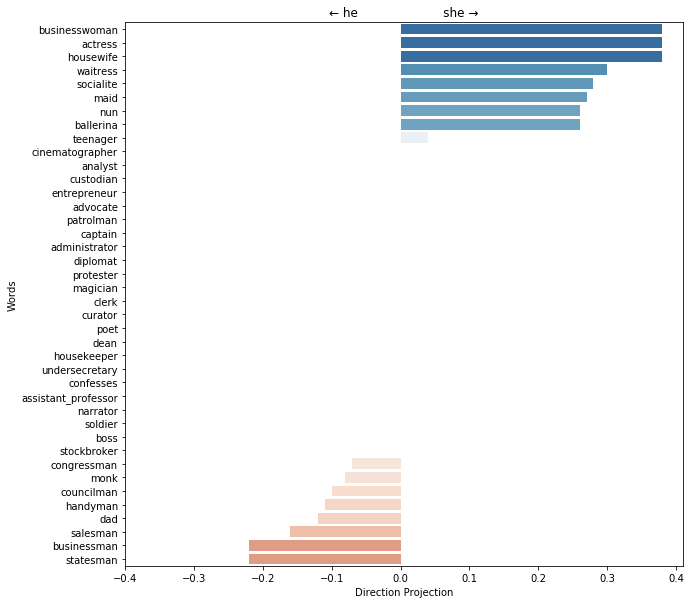

In [279]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

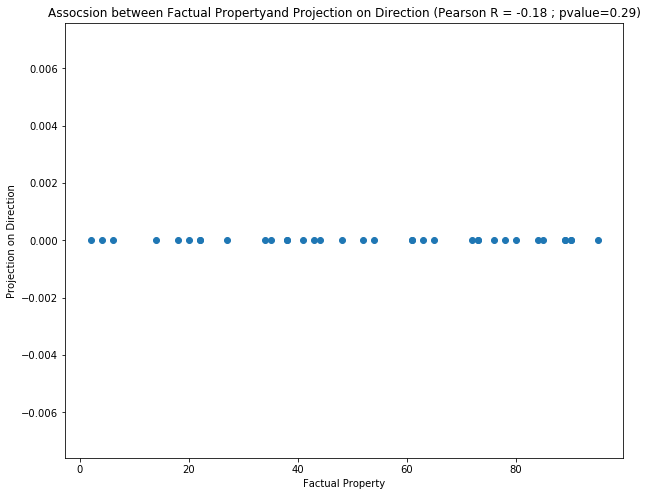

In [280]:
f, ax = plt.subplots(1, figsize=(10, 8))

w2v_small_gender_debias.plot_factual_association(ax=ax);

## 5.2 Equalize

In [281]:
w2v_small_gender_debias.model['grandfather'] @ w2v_small_gender_debias.model['babysitter']

0.30331385

In [282]:
w2v_small_gender_debias.model['grandmother'] @ w2v_small_gender_debias.model['babysitter']

0.4470843

Notice that the projection of "grandfather" and "grandmother" onto the now neutral word "babysitter" are not equal, even though we have "debiased" our embedding. We might prefer that in a "debiased" embedding, "grandfather" and "grandmother" have roughly the same projection onto neutral words. Below you can see an example of some of the pairs we are interested in equalizing.

In [283]:
BOLUKBASI_DATA['gender']['equalize_pairs'][:10]

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['Catholic_priest', 'nun'],
 ['Dad', 'Mom'],
 ['Men', 'Women'],
 ['councilman', 'councilwoman'],
 ['grandpa', 'grandma'],
 ['grandsons', 'granddaughters'],
 ['prostate_cancer', 'ovarian_cancer'],
 ['testosterone', 'estrogen']]

## 5.3 Hard Debias = Neutralize + Equalize

Now we debias by both neutralizing as we did before along with equalizing across the pairs we indentified above (note that the list that was printed out is not exhaustive).

In [284]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='hard', inplace=False)

In [285]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340500455659944 after =  -7.193313097952903e-10


In [286]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.22095191209141335 after =  -0.3469340052748094


In [287]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.340347490056382 after =  0.3469340059022882


In [288]:
w2v_small_gender_debias.calc_direct_bias()

1.26245732368323e-09

In [289]:
w2v_small_gender_debias.model['grandfather'] @ w2v_small_gender_debias.model['babysitter']

0.37519905

In [290]:
w2v_small_gender_debias.model['grandmother'] @ w2v_small_gender_debias.model['babysitter']

0.37519902

Notice that "grandfather" and "grandmother" now have (almost exactly) the same projection onto "babysitter".

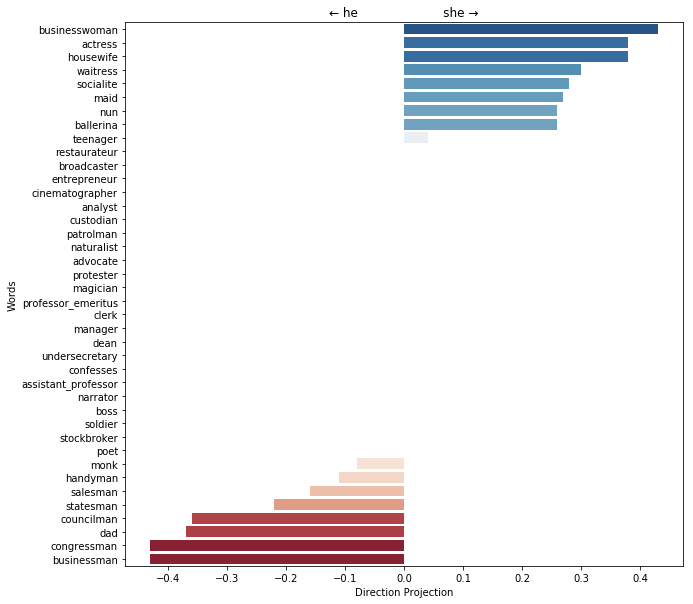

In [291]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

The disadvantage of equalization is that it might remove meaningful associations, such as the verb meaning of "grandfather", e.g. "to grandfather a regulation". Equalization removes this distinction.

## 5.4 - Compare Preformances

After debiasing, the performance of the word embedding (using standard benchmarks) only gets slightly worse!

In [292]:
w2v_small_gender_bias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.645           0.000       0.688            0.000   
 RG65           0.576           0.232       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.650           0.000       0.674            0.000   
 MEN            0.766           0.000       0.782            0.000   
 SimLex999      0.456           0.000       0.444            0.000   
 TR9856         0.666           0.000       0.676            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.750
 Google      0.729)

In [293]:
w2v_small_gender_debias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.643           0.000       0.685            0.000   
 RG65           0.574           0.234       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.651           0.000       0.675            0.000   
 MEN            0.766           0.000       0.782            0.000   
 SimLex999      0.459           0.000       0.447            0.000   
 TR9856         0.665           0.000       0.674            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.751
 Google      0.726)

## 🐳 **Questions** 🐳

- What is "neutralizing", and what is "equalizing" in the context of "hard debiasing", and how do they differ? 
    
    <small>You may find it helpful to look at the following paper from class (you may copy the definitions from the paper, but the explanation on how they differ should be your own):</small>
    <small>[Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](https://arxiv.org/pdf/1607.06520.pdf)</small>

    

# Part 6: Have we really removed the bias?

Gonen, H., & Goldberg, Y. (2019, June). [Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them](https://arxiv.org/pdf/1903.03862.pdf). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 609-614).

They used multiple methods, we'll show only two:
1. WEAT
2. Neutral words clustering

## 6.1 - WEAT


Based on the results of the "hard debiasing" in section **5**, it would appear that we have removed the bias. Is that actually true? Let's look at another metric, called **WEAT** (Word Embedding Association Test) which is inspired by **IAT** (Implicit-Association Test) from Psychology.

Extra: Try the IAT for yourself [https://implicit.harvard.edu/implicit/](https://implicit.harvard.edu/implicit/)

### 6.1.1 - Ingredients of WEAT

1. Attribute words (e.g., Male ve. Female)

2. Target words (e.g., Math vs. Arts)

In [294]:
w2v_small = load_w2v_small()

In [295]:
from responsibly.we.weat import WEAT_DATA

# B. A. Nosek, M. R. Banaji, A. G. Greenwald, Math=male, me=female, therefore math≠me.,
# Journal of Personality and Social Psychology 83, 44 (2002).
weat_gender_science_arts = deepcopy(WEAT_DATA[7])

In [296]:
# filter words from the original IAT experiment that are not present in the reduced Word2Vec model
_filter_by_model_weat_stimuli(weat_gender_science_arts, w2v_small)

In [297]:
weat_gender_science_arts['first_attribute']

{'name': 'Male terms',
 'words': ['brother',
  'father',
  'grandfather',
  'he',
  'him',
  'his',
  'son',
  'uncle']}

In [298]:
weat_gender_science_arts['second_attribute']

{'name': 'Female terms',
 'words': ['aunt',
  'daughter',
  'grandmother',
  'her',
  'hers',
  'mother',
  'she',
  'sister']}

In [299]:
weat_gender_science_arts['first_target']

{'name': 'Science',
 'words': ['astronomy',
  'chemistry',
  'experiment',
  'physics',
  'science',
  'technology']}

In [300]:
weat_gender_science_arts['second_target']

{'name': 'Arts',
 'words': ['dance', 'drama', 'literature', 'novel', 'poetry', 'symphony']}

### 6.1.2 - Calculate WEAT Scores

+ Male x Science (historically high signal)

+ Male x Arts (historically low signal)

+ Female x Science (historically low signal)

+ Female x Arts (historically high signal)

In [301]:
def calc_combination_similiarity(model, attribute, target):
    score = 0

    for attribute_word in attribute['words']:

        for target_word in target['words']:

            score += w2v_small.similarity(attribute_word,
                                          target_word)

    return score

In [302]:
male_science_score = calc_combination_similiarity(w2v_small,
                                                  weat_gender_science_arts['first_attribute'],
                                                  weat_gender_science_arts['first_target'])

male_science_score

3.081121349707246

In [303]:
male_arts_score = calc_combination_similiarity(w2v_small,
                                               weat_gender_science_arts['first_attribute'],
                                               weat_gender_science_arts['second_target'])

male_arts_score

3.844955274835229

In [304]:
female_science_score = calc_combination_similiarity(w2v_small,
                                                    weat_gender_science_arts['second_attribute'],
                                                    weat_gender_science_arts['first_target'])

female_science_score

2.965754544828087

In [305]:
female_arts_score = calc_combination_similiarity(w2v_small,
                                                 weat_gender_science_arts['second_attribute'],
                                                 weat_gender_science_arts['second_target'])

female_arts_score

6.157778291031718

In [306]:
male_science_score - male_arts_score - female_science_score + female_arts_score

2.428189821075648

In [307]:
len(weat_gender_science_arts['first_attribute']['words'])

8

In [308]:
(male_science_score - male_arts_score - female_science_score + female_arts_score) / 8

0.303523727634456

### 6.1.3 - All WEAT Tests

In [325]:
calc_all_weat(w2v_small, [weat_gender_science_arts])

,Target words,Attrib. words,Nt,Na,s,d,p
0,Science vs. Arts,Male terms vs. Female terms,6x2,8x2,0.3035,1.3731,8.7e-03


Results from the Paper (computed on the complete Word2Vec):

<small>Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). [Semantics derived automatically from language corpora contain human-like biases.](http://www.cs.bath.ac.uk/~jjb/ftp/CaliskanEtAl-authors-full.pdf) Science, 356(6334), 183-186.</small>

<small>Important Note: Our results are a bit different because we use a reduced Word2Vec.</small>

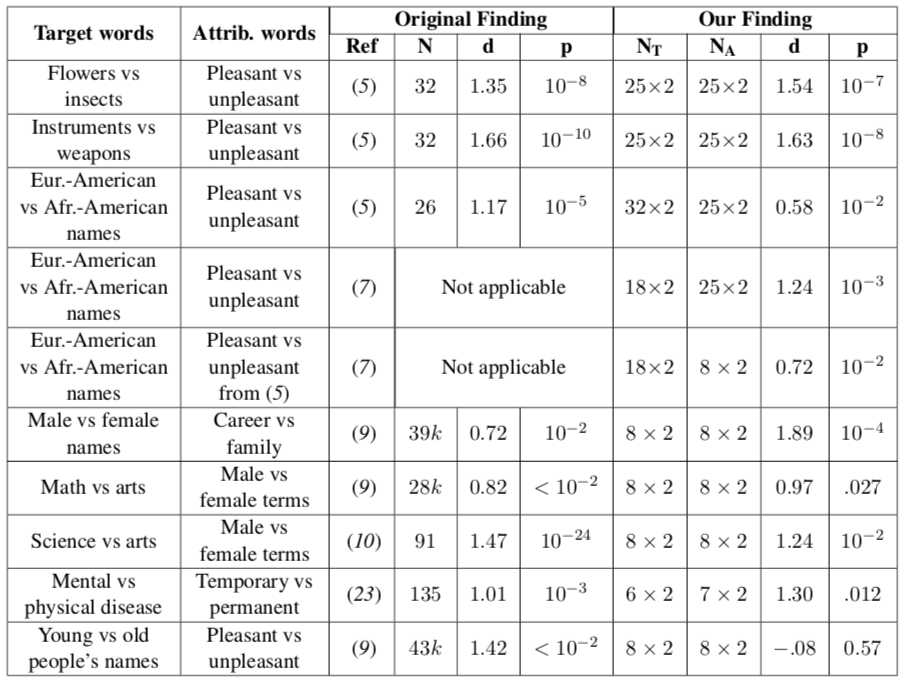

In [310]:
Image("./images/weat-w2v.png", width="600")

#### Comparing WEAT to the IAT

- Individuals (IAT) vs. Words (WEAT)
- Therefore, the meanings of the effect size and p-value are totally different!

#### WEAT score definition

The definition of the WEAT score is structured differently (but it is computationally equivalent). The original formulation matters to compute the p-value. Refer to the paper for details.

#### Effect size comparision between human and machine bias

With the effect size, we can "compare" a human bias to a machine one. It raises the question whether the baseline for meauring bias/fairness of a machine should be human bias? Then a well-performing machine shouldn't be necessarily not biased, but only less biased than human (think about autonomous cars or semi-structured vs. unstructured interview).

## 6.2 - Clustering Gender Neutral Words

In [311]:
w2v_small_gender_bias = GenderBiasWE(w2v_small, only_lower=True)

w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [317]:
from responsibly.we.data import BOLUKBASI_DATA

w2v_vocab = {word for word in w2v_small_gender_bias.model.vocab.keys()}

# how we got these words - read the Bolukbasi's paper for details
all_gender_specific_words = set(BOLUKBASI_DATA['gender']['specific_full_with_definitional_equalize'])

all_gender_neutral_words = w2v_vocab - all_gender_specific_words

print('#vocab =', len(w2v_vocab),
      '#specific =', len(all_gender_specific_words),
      '#neutral =', len(all_gender_neutral_words))

#vocab = 26423 #specific = 1444 #neutral = 26189


In [320]:
neutral_words_gender_projections = [(w2v_small_gender_bias.project_on_direction(word), word)
                                    for word in all_gender_neutral_words]

neutral_words_gender_projections.sort()

In [321]:
neutral_words_gender_projections[:-20:-1]

[(0.3629686562800618, 'petite'),
 (0.3598802214929009, 'bra'),
 (0.3575731516118308, 'sassy'),
 (0.3448009386143032, 'Keisha'),
 (0.3358052183427123, 'Anne'),
 (0.331579716607982, 'pageant'),
 (0.32715674554199603, 'pregnant'),
 (0.3265684447287706, 'Carrie'),
 (0.32361866504855363, 'bras'),
 (0.323251638152222, 'homemaker'),
 (0.3207139457561672, 'breastfeeding'),
 (0.3197391829909521, 'feminine'),
 (0.31682763215108617, 'Tamika'),
 (0.31462604182154735, 'midwife'),
 (0.31292002441038624, 'pregnancy'),
 (0.3076571665635607, 'nurse'),
 (0.3066358292660183, 'Emily'),
 (0.30639927338939765, 'bridal'),
 (0.3062820354129029, 'mums')]

In [322]:
neutral_words_gender_projections[:20]

[(-0.32514106488991185, 'journeyman'),
 (-0.2738591677494378, 'burly'),
 (-0.2655244902853221, 'rookie'),
 (-0.2644344993268166, 'hero'),
 (-0.2558842431558245, 'veteran'),
 (-0.25428981748076496, 'affable'),
 (-0.25197911759635916, 'heir_apparent'),
 (-0.2514780161534102, 'guys'),
 (-0.24924590912692796, 'buddy'),
 (-0.2489809349351275, 'former'),
 (-0.24637932111749675, 'successor'),
 (-0.2444305498389203, 'maestro'),
 (-0.24221288896929455, 'genius'),
 (-0.2414258152628683, 'mild_mannered'),
 (-0.23969201468103357, 'legendary'),
 (-0.2378606964647889, 'bearded'),
 (-0.23629350533001126, 'protege'),
 (-0.23284296597984921, 'legend'),
 (-0.23141318492176965, 'enforcer'),
 (-0.22900291721561525, 'training_camp')]

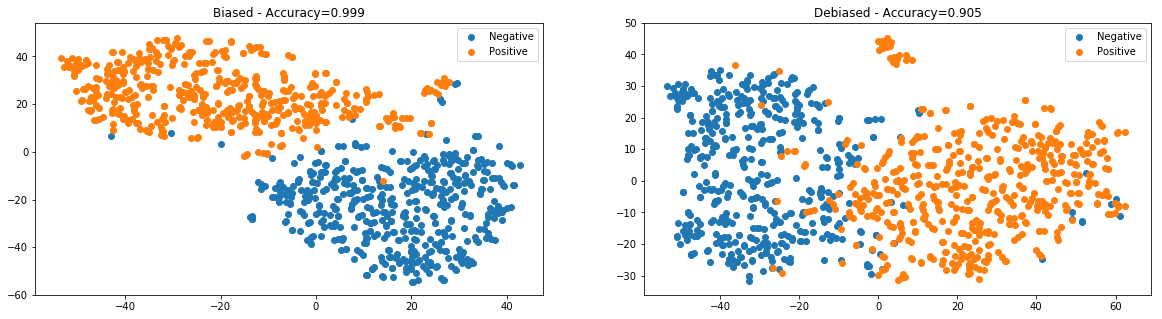

In [323]:
# Neutral words: top 500 male-biased and top 500 female-biased words
GenderBiasWE.plot_most_biased_clustering(w2v_small_gender_bias, w2v_small_gender_debias);

Note: In the paper, they got a stronger result, 92.5% accuracy for the debiased model.
However, they perform clustering on all the words from the reduced word embedding, both gender- neutral and specific words, and applied slightly different pre-processing.

## 6.3 - Quotes from the Paper (Emphasis Added):

>The experiments ...
reveal a **systematic bias** found in the embeddings,
which is **independent of the gender direction**.

<br>

>The implications are alarming: while suggested
debiasing methods work well at removing the gender direction, the **debiasing is mostly superficial**.
The bias stemming from world stereotypes and
learned from the corpus is **ingrained much more
deeply** in the embeddings space.

<br>

> real concern from biased representations is **not the association** of a concept with
words such as “he”, “she”, “boy”, “girl” **nor** being
able to perform **gender-stereotypical word analogies**... algorithmic discrimination is more likely to happen by associating one **implicitly gendered** term with
other implicitly gendered terms, or picking up on
**gender-specific regularities** in the corpus by learning to condition on gender-biased words, and generalizing to other gender-biased words.


## 🐳 **Questions** 🐳

- What does the accuracy listed in the figures in section **6.2** mean? You may have to look at the paper referenced at the beginning of this section.

- Out of the two methods to demonstrate bias explored in this section, which do you think is the most impactful and why?